In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import time


mockdata = np.load("../data/dataset_all_H1_bootstrap_O3a.npy")



In [2]:
mask = np.where(mockdata[:,6] > 0)
mockdata[:,6][mask] = 1

In [3]:
import networklib as nl
# Example usage
if __name__ == "__main__":
    # Synthetic dataset generation (replace with real data)
    num_samples = 1000
    features = torch.tensor(mockdata[:, :6])  # First 6 columns for features
    labels = torch.tensor(mockdata[:, 6])     # 7th column for class labels (multiclass)

    # Ensure labels are integers (already assumed to be 0 to 6)
    # labels = labels.astype(torch.int64)  # Convert to int64 for PyTorch compatibility

    # features = torch.rand(num_samples, 6)  # 6 input features
    # labels = torch.randint(0, 2, (num_samples,))  # Binary classification (0 or 1)

    # Split dataset into training and validation sets
    dataset = TensorDataset(features.float(), labels.long())
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    nepochs = 100
    # Initialize and train the model
    model = nl.GlitchClassifier(6, 16, 2)
    trained_model, loss_list,val_loss_list,accuracy_list,train_loss_list  = nl.train_model(model, train_loader, val_loader, epochs=nepochs, lr=0.001, device='cuda')


Epoch 1/100, Train Loss: 0.4733, Val Loss: 0.3766, Accuracy: 0.8648
Epoch 2/100, Train Loss: 0.3436, Val Loss: 0.3254, Accuracy: 0.8630
Epoch 3/100, Train Loss: 0.3428, Val Loss: 0.3223, Accuracy: 0.8598
Epoch 4/100, Train Loss: 0.3339, Val Loss: 0.3275, Accuracy: 0.8599
Epoch 5/100, Train Loss: 0.3247, Val Loss: 0.3103, Accuracy: 0.8577
Epoch 6/100, Train Loss: 0.3192, Val Loss: 0.3157, Accuracy: 0.8636
Epoch 7/100, Train Loss: 0.3130, Val Loss: 0.2917, Accuracy: 0.8573
Epoch 8/100, Train Loss: 0.3014, Val Loss: 0.2998, Accuracy: 0.8590
Epoch 9/100, Train Loss: 0.2961, Val Loss: 0.2788, Accuracy: 0.8634
Epoch 10/100, Train Loss: 0.2895, Val Loss: 0.2733, Accuracy: 0.8627
Epoch 11/100, Train Loss: 0.2826, Val Loss: 0.2712, Accuracy: 0.8623
Epoch 12/100, Train Loss: 0.2751, Val Loss: 0.2688, Accuracy: 0.8635
Epoch 13/100, Train Loss: 0.2729, Val Loss: 0.2628, Accuracy: 0.8774
Epoch 14/100, Train Loss: 0.2679, Val Loss: 0.2532, Accuracy: 0.8828
Epoch 15/100, Train Loss: 0.2638, Val Loss:

In [9]:
lossconv  = np.array([t.cpu().item() for t in loss_list])
# accconv  = np.array([t for t in accuracy])
accconv = np.array(accuracy_list)
valconv = np.array(val_loss_list)
trainconv = np.array(train_loss_list)

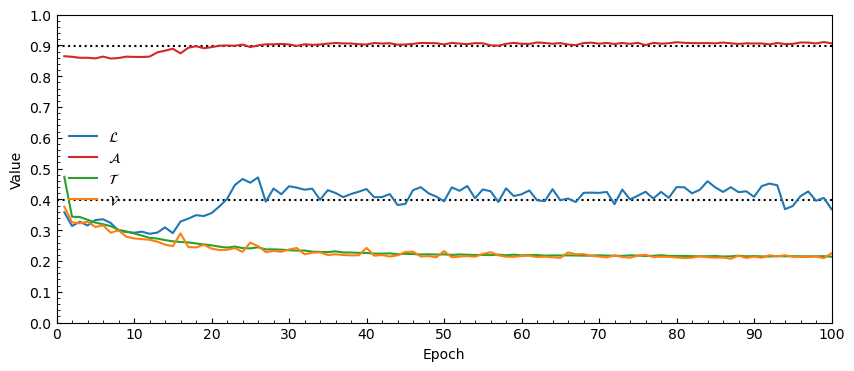

In [15]:

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


epochs = np.arange(1, nepochs+1, 1)


fig, ax = plt.subplots(1, 1, squeeze=  False, figsize = (10, 4))
ax[0,0].plot(epochs, lossconv, label = r"$\mathcal{L}$", zorder= 1, color = "tab:blue")
ax[0,0].plot(epochs, accconv, label = r"$\mathcal{A}$",zorder = 1, color = "tab:red")
ax[0,0].plot(epochs, trainconv, label = r"$\mathcal{T}$",zorder = 1, color = "tab:green")
ax[0,0].plot(epochs, valconv, label = r"$\mathcal{V}$",zorder = 1, color = "tab:orange")
ax[0,0].axhline((lossconv).mean(),zorder= 0,color = "k", linestyle = "dotted")
ax[0,0].axhline((accconv).mean(),zorder= 0,color = "k", linestyle = "dotted")

ax[0,0].tick_params(axis="y",direction="in",which="both")
ax[0,0].tick_params(axis="x",direction="in",which="both")
ax[0,0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0,0].set_xticks(np.arange(0, nepochs + 1, nepochs // 10))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(nepochs//50))
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].set_xlabel("Epoch")
ax[0,0].set_ylabel("Value")
ax[0,0].set_xlim(0, nepochs)
ax[0,0].set_ylim(0, 1)
ax[0,0].legend(frameon=False)
# ax[0,0].grid(True,which="minor")

In [35]:
device = 'cuda'

tmodel = trained_model.to(device)
tfeatures = features.to(device)


tmodel.eval()
logits = tmodel(tfeatures.float())
probs = torch.softmax(logits, dim=1).cpu().detach().numpy()

In [41]:
mask = np.where(labels == 0)
m1_0 = features[:,2][mask]
m2_0 = features[:,3][mask]
p_0 = probs[:,0][mask]
mask = np.where(labels == 1)
m1_1 = features[:,2][mask]
m2_1 = features[:,3][mask]
p_1 = probs[:,1][mask]



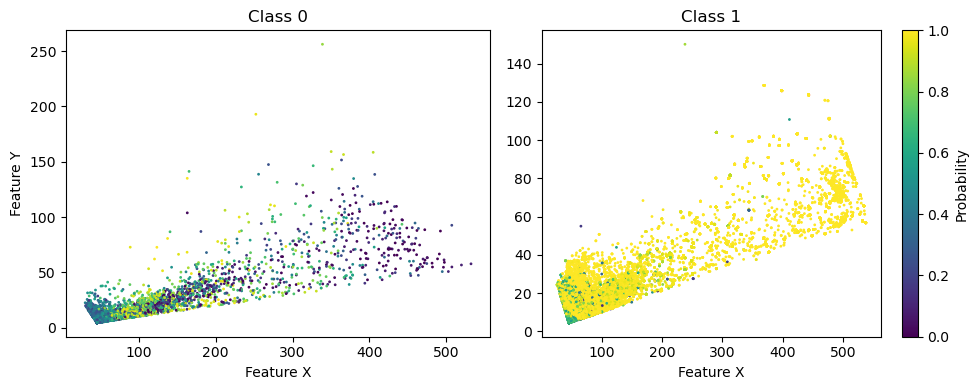

In [ ]:
fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(10, 4))

# Scatter plots with individual color maps
scatter_0 = ax[0, 0].scatter(m1_0, m2_0, c=p_0, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
scatter_1 = ax[0, 1].scatter(m1_1, m2_1, c=p_1, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

# Add a colorbar to the entire figure
cbar = fig.colorbar(scatter_0, ax=ax[0,1], shrink=1)
cbar.set_label("Probability")

# Titles, labels, and adjustments
ax[0, 0].set_title("Class 0 (Gravitational Wave)")
ax[0, 0].set_xlabel("Feature X")
ax[0, 0].set_ylabel("Feature Y")

ax[0, 1].set_title("Class 1 (Noise)")
ax[0, 1].set_xlabel("Feature X")

plt.tight_layout()
plt.show()

